# 3. Luther – Regression

## Imports & Versions

In [1]:
import numpy as np
import pandas as pd
# import requests
# from bs4 import BeautifulSoup
import pickle
from datetime import datetime, timedelta
import time
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
from copy import deepcopy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.externals import joblib
# joblib.dump(lr, 'data/survey_sk_model.pkl')
import statsmodels.api as sm
import statsmodels.formula.api as smf

% matplotlib inline

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# import os
# chromedriver = "/Applications/chromedriver"
# os.environ["webdriver.chrome.driver"] = chromedriver

/Users/dluther/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
list_of_imports = [('Numpy', np), 
                   ('Pandas', pd), 
#                   ('Beautiful Soup', BeautifulSoup), 
#                    ('Selenium', webdriver)
                  ]

for mod in list_of_imports:
    print(f"{mod[0]}: {mod[1].__version__}")

print("Python:", sys.version)

Numpy: 1.13.1
Pandas: 0.20.3
Python: 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [3]:
with open('../data/AAL_clean.pkl', 'rb') as pf: 
    AAL = pickle.load(pf)

## What to Include and How...

In [4]:
AAL.describe()

,lateness_land,lateness_arr,taxi_act,taxi_sch,hour_of_day,q_of_day,weekday
count,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000
mean,7.375074,-10.915134,16.528783,34.818991,14.434421,1.975074,2.785757
std,29.929697,20.120493,8.125203,20.884676,4.350581,0.768653,1.981455
min,-45.000000,-58.000000,0.000000,0.000000,8.000000,1.000000,0.000000
25%,-19.000000,-25.000000,11.000000,14.000000,11.000000,1.000000,1.000000
50%,8.000000,-14.000000,16.000000,40.000000,14.000000,2.000000,3.000000
75%,27.000000,0.000000,19.000000,55.000000,18.000000,3.000000,4.000000
max,100.000000,51.000000,68.000000,77.000000,23.000000,3.000000,6.000000


Next, I'll split off the target column and possible feature columns.

In [5]:
AAL_sub = AAL.filter(['lateness_arr', 'taxi_sch', 'weekday', 'hour_of_day', 'q_of_day', 'f_num'])

...then inspect with corr / pair plot.

In [6]:
AAL_sub.corr()

,lateness_arr,taxi_sch,weekday,hour_of_day,q_of_day
lateness_arr,1.000000,0.107158,-0.144172,0.039277,0.046443
taxi_sch,0.107158,1.000000,-0.030757,-0.019028,-0.005090
weekday,-0.144172,-0.030757,1.000000,-0.028393,-0.035479
hour_of_day,0.039277,-0.019028,-0.028393,1.000000,0.933375
q_of_day,0.046443,-0.005090,-0.035479,0.933375,1.000000


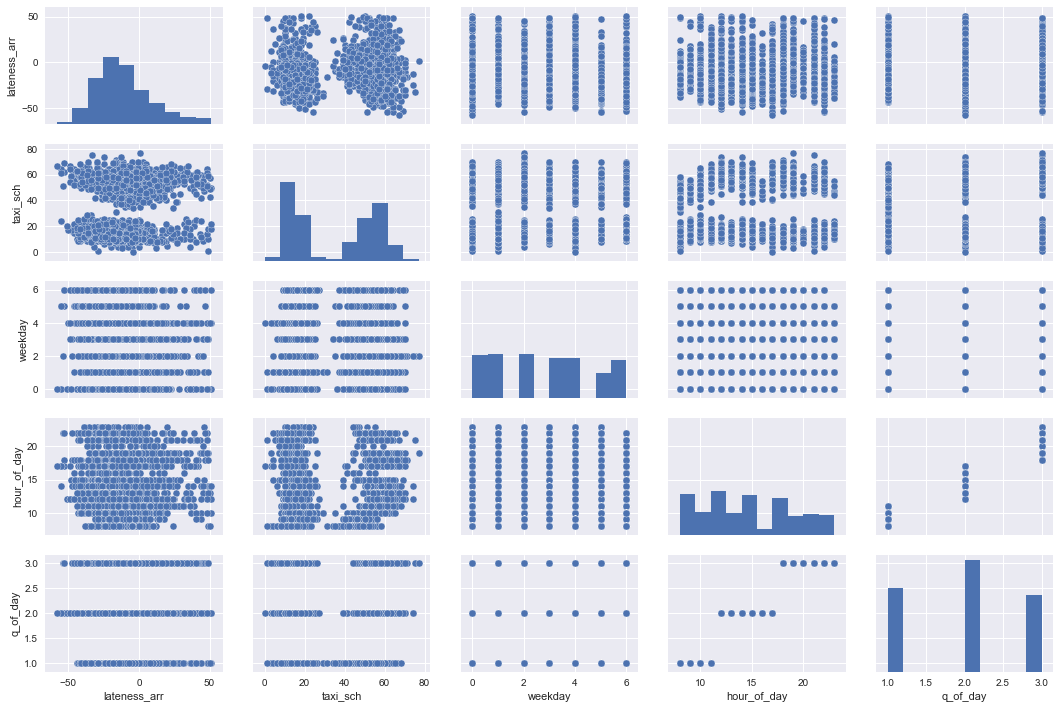

In [7]:
sns.pairplot(AAL_sub, size=2, aspect=1.5);

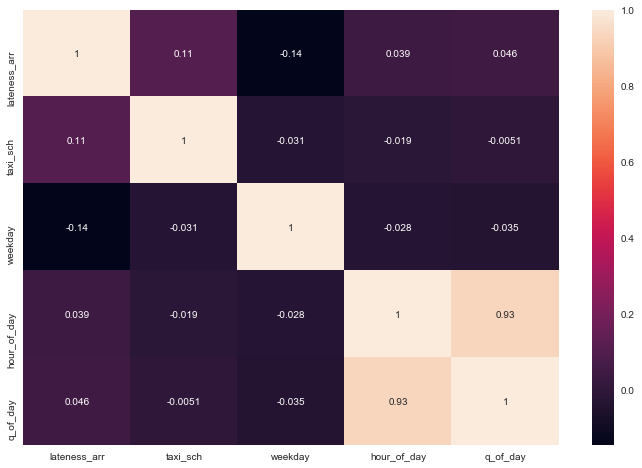

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(AAL_sub.corr(), annot=True);

#plt.savefig('../img/heatmap.png', dpi=200, bbox_inches = 'tight')

Very weak negative correlation spotted with **weekday** and **lateness_arr**. Colinearity found with **hour_of_day** and **q_of_day** is not surprising, as the former is a roughly a subset of the latter. Thus, it would be best to use one or the other when modeling.

Now, convert categorical vars to dummy cols. Two sets to start with:

In [9]:
AAL_sub_twqf = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
          'f_num'
         ])
           )

In [10]:
AAL_sub_twh = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
#          'f_num'
         ])
           )

In [11]:
AAL_twqf = (pd
            .get_dummies(AAL_sub_twqf, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [12]:
AAL_twh = (pd
            .get_dummies(AAL_sub_twh, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [13]:
AAL_twqf.columns

Index(['lateness_arr', 'taxi_sch', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'q_of_day_2', 'q_of_day_3',
       'f_num_AAL187', 'f_num_AAL289', 'f_num_AAL304', 'f_num_AAL321',
       'f_num_AAL328', 'f_num_AAL332', 'f_num_AAL337', 'f_num_AAL343',
       'f_num_AAL345', 'f_num_AAL358', 'f_num_AAL359', 'f_num_AAL361',
       'f_num_AAL371', 'f_num_AAL373', 'f_num_AAL383', 'f_num_AAL390'],
      dtype='object')

In [14]:
AAL_twh.columns

Index(['lateness_arr', 'taxi_sch', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_of_day_9',
       'hour_of_day_10', 'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13',
       'hour_of_day_14', 'hour_of_day_15', 'hour_of_day_16', 'hour_of_day_17',
       'hour_of_day_18', 'hour_of_day_19', 'hour_of_day_20', 'hour_of_day_21',
       'hour_of_day_22', 'hour_of_day_23'],
      dtype='object')

In [15]:
AAL.q_of_day.value_counts()

2    689
1    519
3    477
Name: q_of_day, dtype: int64

Since there are no flights scheduled to land between midnight and 6am, there are no zeros for the q_of_day (quarter of day) column, and thus only two dummies for that column. All others appear as expected.

#### Heat Map of Scheduled Taxi Time, Weekday, Quarter of Day, Flight Number

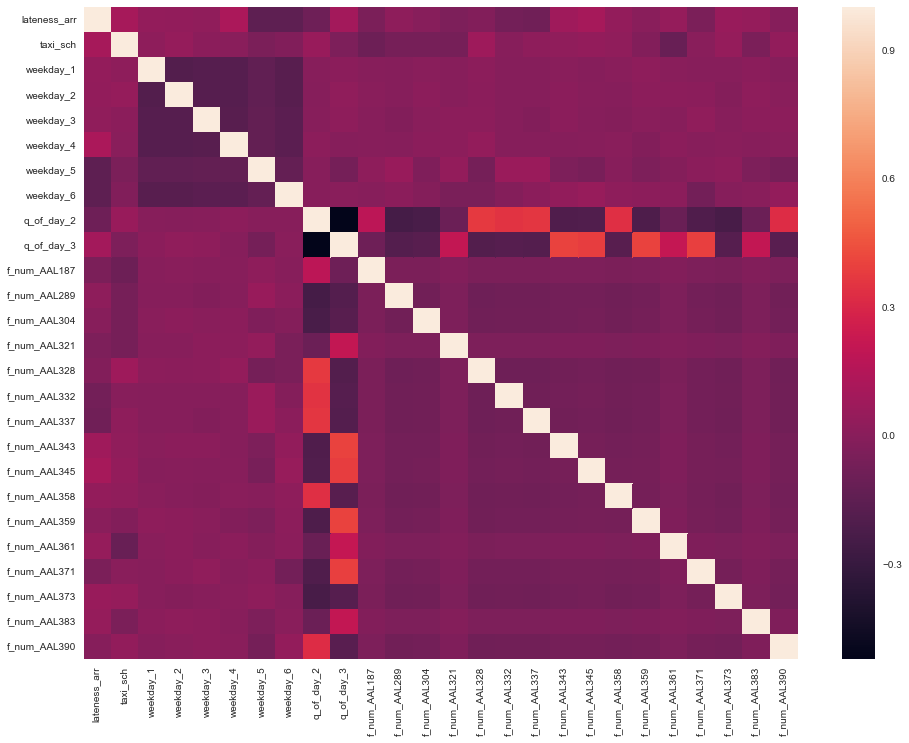

In [16]:
plt.figure(figsize=(16,12))
sns.heatmap(AAL_twqf.corr());

Not surprising that flight numbers show some correlation to the quarter of day in which they fall, which would be even more pronounced with hour of day. I'm suspecting that having both features in the model won't result in superior performance (perhaps a better MSE and larger R<sup>2</sup> value, but R<sup>2</sup>adj would suffer — we will test this).

#### Heat Map of Scheduled Taxi Time, Weekday, Hour of Day

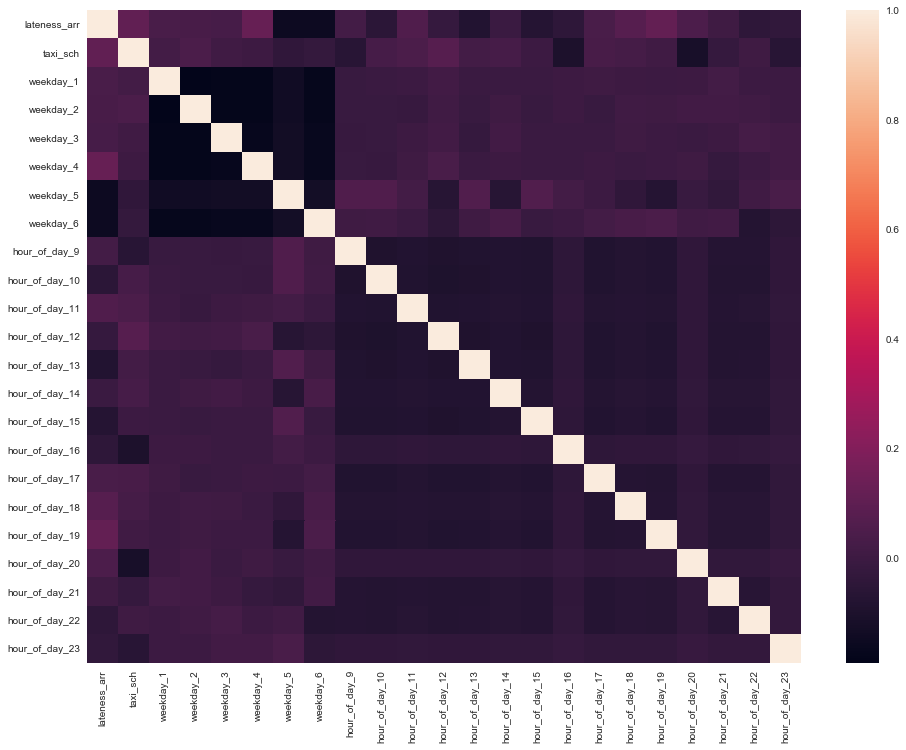

In [17]:
plt.figure(figsize=(16,12))
sns.heatmap(AAL_twh.corr());

## Let's Get To Regression

I should wrap this all into a class before Friday... in all the spare time!

In [18]:
def quick_lr(X, y, random_state=23):
    """
    Test/Train splits at 20/80, fits a LR to all features in X_train,
    then predicts based on X_test.
    """
    lr = LinearRegression()
    X_tr, X_ts, y_tr, y_ts = tts(X, y, test_size=0.20, random_state=random_state)
    lr.fit(X_tr, y_tr)
    y_hat = lr.predict(X_ts)
    
    MSE = mean_squared_error(y_ts, y_hat)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_ts, y_hat)
    r2 = lr.score(X_ts, y_ts)
    ar2 = adj_r2(r2, X_ts.shape[0], X_ts.shape[1])
                              
    print("R-squared (full):", lr.score(X, y))
    print("R-squared (test):", r2)
    print("Adj R-Squared (test):", ar2)
    # print("MSE:", MSE)
    print("RMSE:", RMSE)
    print("MAE:", MAE)
    
    return y_hat, y_ts

In [19]:
def adj_r2(rsquare, num_data, num_features):
    temp = (1-rsquare)*(num_data-1)
    temp = temp/(num_data-num_features-1)
    temp = 1 - temp
    return temp

In [20]:
def quick_yvy_scatter(ys):
    """
    Quick/dirty scatterplot of predicted v. real targets.
    """
    y_hat, y_act = ys
    plt.figure(figsize=(10,6))
    plt.scatter(y_hat, y_act)
    plt.xlabel("Predicted Targets")
    plt.ylabel("Actual Targets")

### 1. Taxi, Weekday, Quarter of Day, Flight Number

R-squared (full): 0.107497213697
R-squared (test): 0.11966443248
Adj R-Squared (test): 0.0488979077592
RMSE: 18.60818803
MAE: 14.2155671074


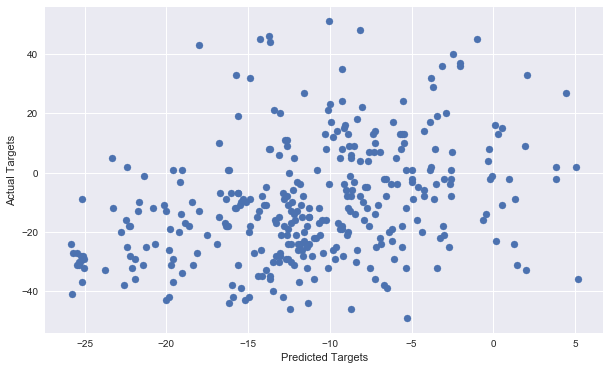

In [21]:
y_twqf = AAL_twqf.iloc[:, 0]
X_twqf = AAL_twqf.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twqf, y_twqf, random_state=23))

### 2. Taxi, Weekday, Hour of Day, Flight Number

In [22]:
AAL_sub_twhf = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
          'f_num'
         ])
           )

AAL_twhf = (pd
            .get_dummies(AAL_sub_twhf, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day', 
                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.107658506308
R-squared (test): 0.12002961769
Adj R-Squared (test): 0.0078186293416
RMSE: 18.6043280588
MAE: 14.2153709253


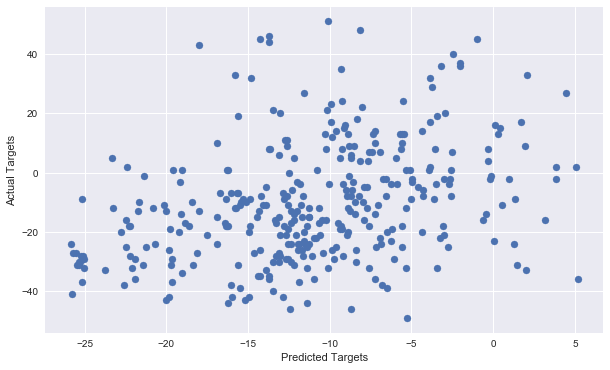

In [23]:
y_twhf = AAL_twhf.iloc[:, 0]
X_twhf = AAL_twhf.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twhf, y_twhf, random_state=23))

This one shows some very strange behavior when certain random states are chosen (try some for kicks). Predicts some very extreme values. FN is probably out.

### 3. Taxi, Weekday, Quarter of Day

In [24]:
AAL_sub_twq = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_twq = (pd
            .get_dummies(AAL_sub_twq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.0765902767155
R-squared (test): 0.089876732317
Adj R-Squared (test): 0.0648274680688
RMSE: 18.9203893928
MAE: 14.5604510851


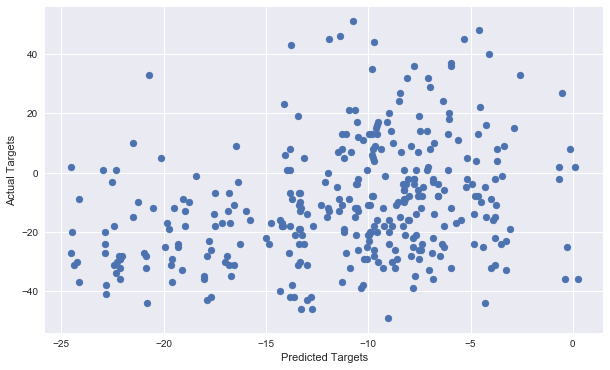

In [25]:
y_twq = AAL_twq.iloc[:, 0]
X_twq = AAL_twq.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twq, y_twq, random_state=23))

### 4. Taxi, Weekday, Hour of Day

R-squared (full): 0.106676434212
R-squared (test): 0.118400594134
Adj R-Squared (test): 0.0566324828947
RMSE: 18.6215404991
MAE: 14.2122122025


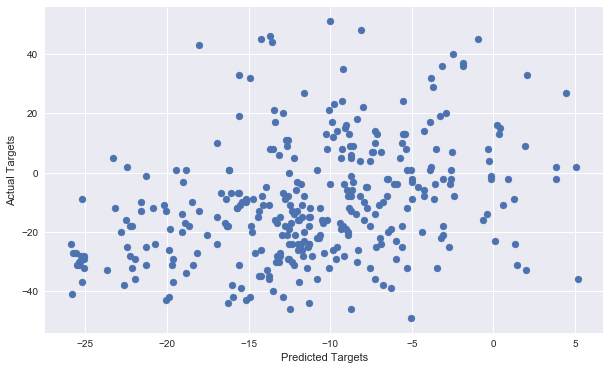

In [26]:
y_twh = AAL_twh.iloc[:, 0]
X_twh = AAL_twh.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twh, y_twh, random_state=23))

### 5. Weekday, Quarter of Day

In [27]:
AAL_sub_wq = (AAL_sub
 .filter(['lateness_arr',
#          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_wq = (pd
            .get_dummies(AAL_sub_wq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.0666668782348
R-squared (test): 0.0648092431733
Adj R-Squared (test): 0.041999712519
RMSE: 19.1791812913
MAE: 14.8337373685


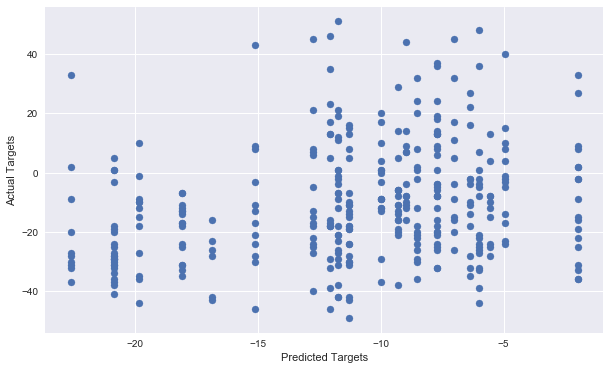

In [28]:
y_wq = AAL_wq.iloc[:, 0]
X_wq = AAL_wq.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_wq, y_wq, random_state=23))

### 6. Weekday, Hour of Day

In [29]:
AAL_sub_wh = (AAL_sub
 .filter(['lateness_arr',
#          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
#          'f_num'
         ])
           )

AAL_wh = (pd
            .get_dummies(AAL_sub_wh, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.097754257476
R-squared (test): 0.0937099960372
Adj R-Squared (test): 0.0332906624396
RMSE: 18.8805028338
MAE: 14.470554223


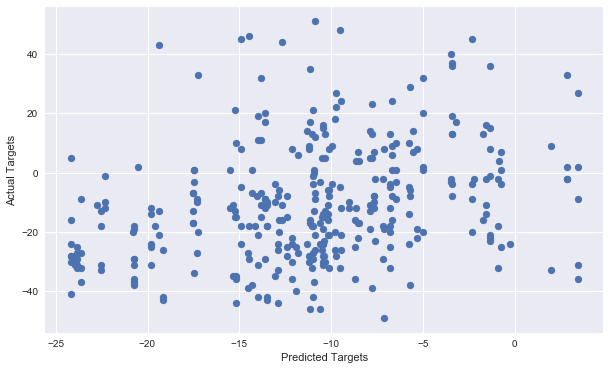

In [30]:
y_wh = AAL_wh.iloc[:, 0]
X_wh = AAL_wh.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_wh, y_wh, random_state=23))

Because of the trouble that the flight number gave in the final trial above, and the fact that each one is colinear with some hour or quarter of the day, I won't pursue it as a feature. 

Nothing provided particualarly promising scores, but , focusing on day of week and time of day. Will investigate each with and without taxi time.

1. Weekday, Hour of Day, Taxi Time
2. Weekday, Quarter of Day, Taxi Time
3. Weekday, Hour of Day
4. Weekday, Quarter of Day

## Cross-Validation in 10 Minutes

**Abbreviations:** cvs = cross_val_score(), cvp = cross_val_predict()

In [31]:
def coarse_grid_search(feat_arrs, folds=5):
    """
    Feed list of possible feature arrays (X,y) tuple pais and fold number, 
    spit out RMSE for each fold and the mean RMSE for all.
    """
    
    for n, pair in enumerate(feat_arrs):
        lr = LinearRegression()
        X, y = pair
        nmse_scores = cvs(lr, X, y, cv=folds, scoring='neg_mean_squared_error')
        rmse_scores = [np.sqrt(-1 * i) for i in nmse_scores]
        mean_rmse = sum(rmse_scores) / folds
        
        print("\n*** Model", n+1)
        print(rmse_scores)
        print("Mean RMSE:", mean_rmse)

In [32]:
feature_arrays = [(X_twq, y_twq),
                  (X_twh, y_twh),
                  (X_wq, y_wq),
                  (X_wh, y_wh)
                 ]

In [33]:
coarse_grid_search(feature_arrays, folds=10)


*** Model 1
[23.113131605701547, 21.458607793932817, 23.836808429207942, 18.083208546652752, 20.822773821353532, 21.188433915488492, 18.757278979482855, 16.80776727766494, 13.938348395044059, 17.484984013423475]
Mean RMSE: 19.5491342778

*** Model 2
[21.276451407365645, 20.750803965731286, 23.387589089631053, 17.915533020552783, 23.936235861435033, 21.634669535214993, 18.796101789165192, 16.713551045544854, 13.952376708346119, 17.49513515473306]
Mean RMSE: 19.5858447578

*** Model 3
[23.579392811281316, 21.66198759073162, 23.854581838670935, 18.437538649596345, 20.916241556153071, 21.03352929021619, 19.140517880077663, 16.798589558978822, 13.898850359298212, 17.246035486812197]
Mean RMSE: 19.6567265022

*** Model 4
[21.600137983469395, 21.205714865741928, 23.305020906276656, 18.223157084707257, 23.364486057496332, 21.891926626177042, 19.095204710221505, 16.711501872789739, 14.038783695356544, 17.385014107972555]
Mean RMSE: 19.682094791


All four feature sets performed about as poorly, though Model 1 (Taxi Time, Weekday, Quarter of Day) performed slightly better than the others, with a mean RMSE of 19.5 minutes. This one also received the best adjusted-R<sup>2</sup> score of 0.065, so we'll go to production with it.

#### Training the holy model...

In [89]:
holy_model = LinearRegression()
holy_model.fit(X_twq, y_twq)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

And it's now ready to see some wild data.

## Model Meets Validation Set

In [90]:
with open('../data/AAL_test.pkl', 'rb') as pf: 
    AAL_val = pickle.load(pf)

Boil down to the same format as the training set, pull out features and target:

In [91]:
AAL_val_sub = AAL_val.filter(['lateness_arr', 
                              'taxi_sch', 
                              'weekday', 
                              'hour_of_day', 
                              'q_of_day', 
                              'f_num'
                             ])

AAL_val_twq = (AAL_val_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_val = (pd
            .get_dummies(AAL_val_twq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [92]:
AAL_val.head()

,lateness_arr,taxi_sch,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,q_of_day_2,q_of_day_3
0,-29,17,0,0,0,0,0,0,0,1
1,-24,10,0,0,0,0,1,0,0,1
2,-25,10,0,0,1,0,0,0,0,1
3,-5,15,0,0,0,0,0,0,0,1
4,-17,8,0,0,0,0,1,0,0,1


In [93]:
y_val = AAL_val.iloc[:, 0]
X_val = AAL_val.iloc[:, 1:]

### The Model Predicts

In [94]:
y_hat = holy_model.predict(X_val)

In [95]:
MSE_val = mean_squared_error(y_val, y_hat)
RMSE_val = np.sqrt(MSE_val)
print("RMSE:", RMSE_val)

RMSE: 14.8036197403


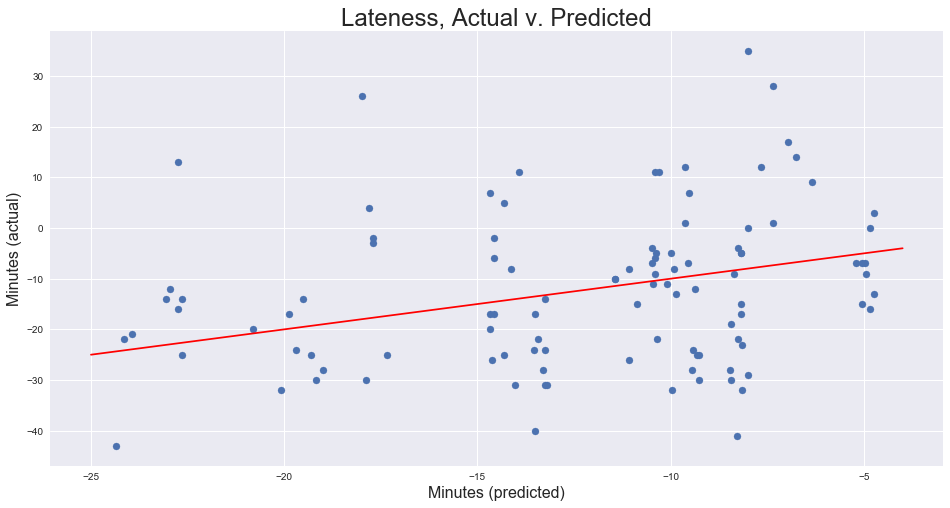

In [105]:
line = np.linspace(-25, -4, 50)

plt.figure(figsize=(16,8))
plt.scatter(y_hat, y_val)
plt.plot(line, line, 'r-')
plt.xlabel("Minutes (predicted)", fontsize=16)
plt.ylabel("Minutes (actual)", fontsize=16)
plt.title("Lateness, Actual v. Predicted", fontsize=24);

#plt.savefig('../img/test_noline.png', dpi=200, bbox_inches = 'tight')

Not so good...

### Can it at least beat the dummy??

In [106]:
dr = DummyRegressor()

In [107]:
dr.fit(X_twq, y_twq)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [108]:
y_twq.mean()

-10.91513353115727

In [109]:
y_dumdum = dr.predict(X_val)

In [110]:
MSE_dumdum = mean_squared_error(y_val, y_dumdum)
RMSE_dumdum = np.sqrt(MSE_dumdum)
print("RMSE (model):", RMSE_val)
print("RMSE (dummy):", RMSE_dumdum)

RMSE (model): 14.8036197403
RMSE (dummy): 15.2576156859


Beat by 0.46!!